# 1 Design gait and basic functions

In [1]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
# from sympy import symbols
# from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy.utilities.lambdify import lambdify
# from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy import interpolate

In [2]:
## Motor constants
K = 0.0285;                 # Nm / A
peak_amp = 30;              # A
peak_torque = K * peak_amp; # Nm
m_motor = 0.2;              # kg
m_assembly = 0.2;           # kg

m_total = 2*m_motor + m_assembly; # kg

gravity = 9.8;              # m/s^2

weight = m_total * gravity  # N

l1 = 0.09;                  # m 
l2 = 0.16;                  # m
w = 0.07;                   # m

T = 0.25;                   # s
d = 0.5;
N = 100;

In [3]:
# solve jacobian of constraint equation
(thetaL_sym, 
 thetaR_sym, 
 link1_sym, 
 link2_sym, 
 width_sym) = sp.symbols("""thetaL_sym 
                            thetaR_sym 
                            link1_sym 
                            link2_sym 
                            width_sym""", real = True)

In [4]:
def T(theta, x, y):
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), x], 
                      [sp.sin(theta), sp.cos(theta), y],
                      [0, 0, 1]])

def sym_to_np(T):
    return np.array(T).astype(np.float64)

## 1.1 FK Through transformation matrices

In [5]:
x_r = width_sym/2 + link1_sym*sp.cos(thetaR_sym)
x_l = -width_sym/2 + link1_sym*sp.cos(thetaL_sym)

y_r = link1_sym*sp.sin(thetaR_sym)
y_l = link1_sym*sp.sin(thetaL_sym)

theta3_sym = sp.atan2(y_r - y_l, x_r - x_l)
L = sp.sqrt((x_l - x_r)**2 + (y_l - y_r)**2)

FK = T(thetaL_sym, -width_sym/2, 0)@T(-(thetaL_sym - theta3_sym), link1_sym, 0)@sp.Matrix([L/2, sp.sqrt(link2_sym**2 - (L/2)**2), 1])
FK = FK[:2,:]
FK.simplify()
FK_fast = FK.subs([(link1_sym, l1), (link2_sym, l2), (width_sym, w)]).evalf()
# lambdify the forward kinematics (makes it faster)
FK_lambda = lambdify((thetaR_sym, thetaL_sym), FK_fast)


## 1.2 IK Through Fsolve method

In [6]:
def IK_constraint_eqn(x, x_pt, y_pt, l1, l2, w):
    theta_R = x[0]
    theta_L = x[1]
    
    return (l1**2 - l2**2 + (x_pt - w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_R) + (x_pt - w/2)*np.cos(theta_R)),
            l1**2 - l2**2 + (x_pt + w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_L) + (x_pt + w/2)*np.cos(theta_L)))

## 1.3 define a function to transport gait to angle versus time

In [68]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

def gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, T, d, N, leg_position):    
    if leg_position == 1:
        x_on = -x_on
        x_off = -x_off
        x_sw = -x_sw
    
    N_st = np.int64(N*d)  
    N_sw = np.int64(N*(1-d))

    # generate line of stance
    x = np.array([x_on,x_off])
    y = np.array([y_on,y_off])
    z = np.polyfit(x, y, deg = 1)
    poly_st = np.poly1d(z)
    x_st = np.linspace(x_on, x_off, N_st+1)
    
    # generate poly of swing
    x = np.array([x_off,x_sw,x_on])
    y = np.array([y_off,y_sw,y_on])
    z = np.polyfit(x, y, deg = 2)
    poly_sw = np.poly1d(z)
    x_sw = np.linspace(x_off, x_on, N_sw+1)

    # plot gait
    plt.figure()
    st_line = plt.plot(x_st, poly_st(x_st),'b', label="Stance phase")[0]
    add_arrow(st_line)
    sw_curve = plt.plot(x_sw, poly_sw(x_sw),'r', label="Swing phase")[0]
    add_arrow(sw_curve)
    plt.plot(x_st[0], poly_st(x_st[0]), 's', label="ON position")
    plt.plot(x_st[-1], poly_st(x_st[-1]), 'o', label="OFF position")
    if leg_position == 1:
        plt.plot(x_st[-1], poly_st(x_st[-1]), 'o', markersize=12, label="START position")
    else:
        plt.plot(x_st[0], poly_st(x_st[0]), 'o', markersize=12, label="START position")
    plt.title('Gait trajectory')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    
    all_pts  = []
    
    y_st = poly_st(x_st)
    y_sw = poly_sw(x_sw)
    
    all_x = np.append(x_st, x_sw)
    all_y = np.append(y_st, y_sw)
    
    for idx, x in enumerate(all_x):
        all_pts.append((x, all_y[idx]))
        
    
    print('gait origin is ', np.mean(all_x), np.mean(all_y))
    
    # stance gait to angle
    theta_st = np.zeros(shape=(N_st+1,2))
    i = 0
    for j in x_st:
        theta_st[i] = fsolve(lambda x: IK_constraint_eqn(x, j, poly_st(j), l1, l2,w), (0,np.pi))
        i = i+1
    
    # swing gait to angle
    theta_sw = np.zeros(shape=(N_sw+1,2))
    i = 0
    for j in x_sw:
        theta_sw[i] = fsolve(lambda x: IK_constraint_eqn(x, j, poly_sw(j), l1, l2,w), (0,np.pi))
        i = i+1
    
    # plot angle versus time
    plt.figure()
    if leg_position == 0:
        theta_sw = np.delete(theta_sw, 0, 0)
        theta = np.append(theta_st, theta_sw, axis = 0)
    elif leg_position == 1:
        theta_st = np.delete(theta_st, 0, 0)
        theta = np.append(theta_sw, theta_st, axis = 0)
         
    t = np.linspace(0, T, N+1)
    plt.plot(t, theta[:, 0],'r')
    plt.plot(t, theta[:, 1],'b')
    plt.title('Angle versus time')
    plt.xlabel('t (s)')
    plt.ylabel('θ (rad)')
    plt.legend(['${θ_R}$','${θ_L}$'])
        
    return (theta, np.mean(all_x), np.mean(all_y), all_pts)

## 1.4 plot the gait(top) & angle versus time(bottom)

gait origin is  -5.442269728554689e-19 0.16713333333333336


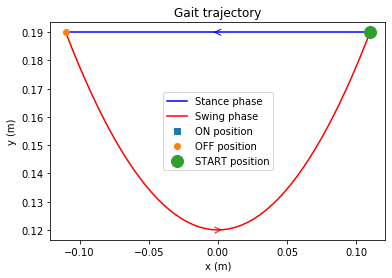

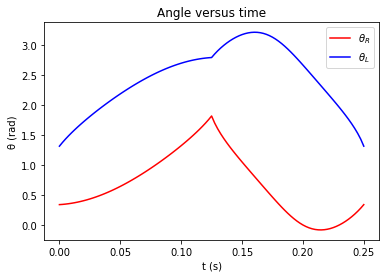

In [8]:
theta1, origin_x, origin_y = gait2angle(0.11,0.19,-0.11,0.19,0,0.12,0.25,0.5,100,0)

gait origin is  5.442269728554689e-19 0.16713333333333336


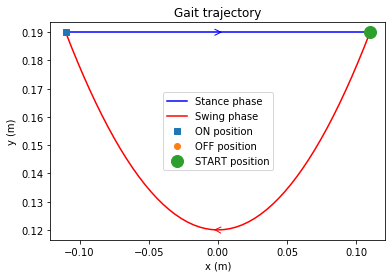

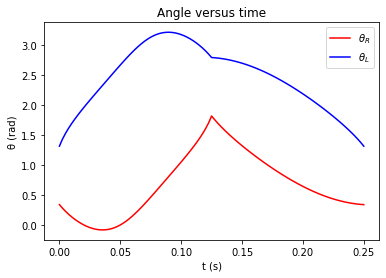

In [9]:
theta2, origin_x, origin_y = gait2angle(0.11,0.19,-0.11,0.19,0,0.12,0.25,0.5,100,1)

# Gait design and selection

## Left leg

gait origin is  -0.017565095537107597 0.13955161251327014


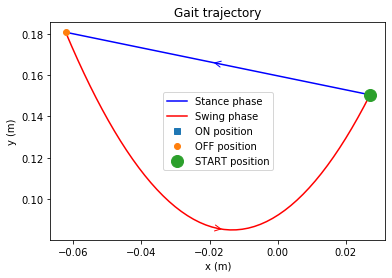

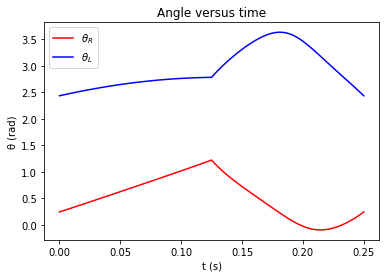

In [10]:
x_on = 0.0271340208767868
y_on = 0.150504090025698
x_off = -0.0622642119510020
y_off = 0.180845634937132

x_sw = -0.0210965760128508
y_sw = 0.0874034639992732

LEFT_LEG = 0
RIGHT_LEG = 1

T            = 0.25        # seconds
dutyfactor   = 0.5         # duty factor (higher means more )
N            = 100         # no. of trajectory points
leg_position = LEFT_LEG    # which leg?

theta1, origin_x, origin_y = gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, \
                    T, dutyfactor, N, leg_position)

gait origin is  0.017565095537107597 0.13955161251327014


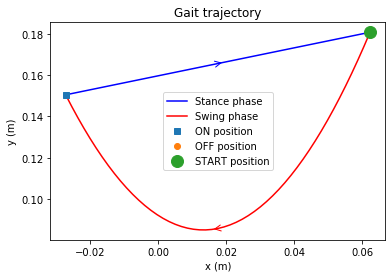

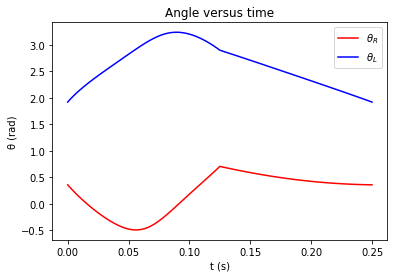

In [11]:
leg_position = RIGHT_LEG    # which leg?

theta2, origin_x, origin_y = gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, \
                    T, dutyfactor, N, leg_position)

# 2 Precompute and interpolate the transform funtions

## 2.1 define trajectory parameters

gait origin is  -0.0125650955371076 0.13542513784180127
gait origin is  0.0125650955371076 0.13542513784180127


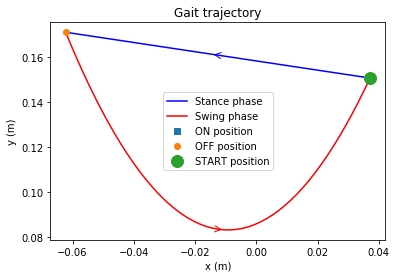

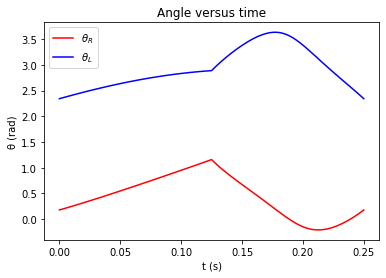

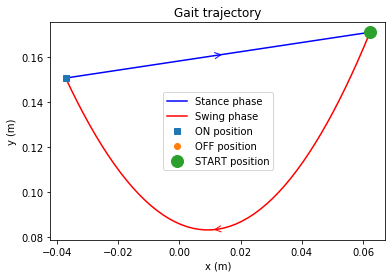

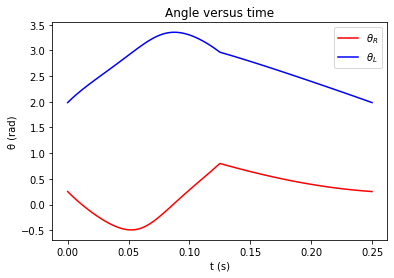

In [358]:
# y_shift = 0.02
# x_pos = 0.07
# x_on = 0.03
# y_on = 0.2-y_shift
# x_off = -0.07
# y_off = 0.2-y_shift
# x_sw = 0
# y_sw = 0.08

# y_origin = (y_off + y_sw)/2
# x_origin = (x_on + x_off)/2

trajectories = [
    {'x_on': 0.0271340208767868,
     'y_on': 0.150504090025698,
     'x_off': -0.0622642119510020,
     'y_off': 0.180845634937132,
     'x_sw': -0.0210965760128508,
     'y_sw': 0.0874034639992732,
    },
    {
     'x_on': 0.0371340208767868,
     'y_on': 0.150504090025698,
     'x_off': -0.0622642119510020,
     'y_off': 0.170845634937132,
     'x_sw': -0.0210965760128508,
     'y_sw': 0.0874034639992732,
    }]

trajectory = "2"
traj = trajectories[int(trajectory)-1]
# load trajectory parameters (on, off and swing points)
x_on = traj['x_on']
y_on = traj['y_on']
x_off = traj['x_off']
y_off = traj['y_off']
x_sw = traj['x_sw']
y_sw = traj['y_sw']

LEFT_LEG = 0
RIGHT_LEG = 1


T          = 0.25 # seconds
dutyfactor = 0.5 # dutyfactor
N          = 100 # number of trajectory points

# calculate the gait/trajectory's origin (using left leg always!)
_, origin_x, origin_y, allpts = gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, \
                    T, dutyfactor, N, LEFT_LEG)

_, a, b, allpts_R = gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, \
                    T, dutyfactor, N, RIGHT_LEG)

x_origin = origin_x
y_origin = origin_y

psi_left = sp.atan2((y_off-y_origin),(x_off-x_origin))
psi_right = sp.atan2((y_on-y_origin),(x_on-x_origin))

x = np.array([x_on-x_origin,x_off-x_origin])
y = np.array([y_on-y_origin,y_off-y_origin])
z_st = np.polyfit(x, y, deg = 1)
poly_st = np.poly1d(z_st)
y_st = z_st[1]

x = np.array([x_off-x_origin,x_sw-x_origin,x_on-x_origin])
y = np.array([y_off-y_origin,y_sw-y_origin,y_on-y_origin])
z_sw = np.polyfit(x, y, deg = 2)
poly_sw = np.poly1d(z_sw)
# y_sw = z_sw

## 2.2 define ψ to motor angle function & get current ψ function

In [13]:
# ψ to motor angle function for left odrive
def psi2angleL(psi,x_on=x_on,y_on=y_on,x_off=x_off,y_off=y_off,x_sw=x_sw,y_sw=y_sw,x_origin=x_origin,y_origin=y_origin):

    #whether psi matches the swing or stance
    if psi_right<psi<psi_left:
        #calculate the x,y position related to psi
        if psi == sp.pi/2 or psi == np.pi/2:
            cal_x = 0
        else:
            x = sp.symbols('x')
            cal_x = y_st/sp.tan(psi)
        cal_y = y_st
    else:
        x = sp.symbols('x')
        cal_x = sp.solve(sp.tan(psi) - poly_sw(x)/x,x)
        if psi == sp.pi/2*3 or psi == np.pi/2*3:
            cal_x = 0 
        elif sp.pi/2<psi<sp.pi/2*3:
            if cal_x[0]<0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        elif psi>sp.pi/2*3 or psi<sp.pi/2:
            if cal_x[0]>=0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        cal_y = poly_sw(cal_x)
    
    cal_x = cal_x + x_origin
    cal_y = cal_y + y_origin
        
    theta_motor = fsolve(lambda x: IK_constraint_eqn(x, cal_x, cal_y, l1, l2,w), (0,np.pi))    
    
    return(theta_motor)

In [14]:
# ψ to motor angle function for right odrive
def psi2angleR(psi,x_on=x_on,y_on=y_on,x_off=x_off,y_off=y_off,x_sw=x_sw,y_sw=y_sw,x_origin=x_origin,y_origin=y_origin):

    #whether psi matches the swing or stance
    if psi_right<psi<psi_left:
        #calculate the x,y position related to psi
        if psi == sp.pi/2 or psi == np.pi/2:
            cal_x = 0
        else:
            x = sp.symbols('x')
            cal_x = sp.solve(sp.tan(psi) - poly_st(x)/x,x)[0]
        cal_y = poly_st(cal_x)
    else:
        x = sp.symbols('x')
        cal_x = sp.solve(sp.tan(psi) - poly_sw(x)/x,x)
        if psi == sp.pi/2*3 or psi == np.pi/2*3:
            cal_x = 0 
        elif sp.pi/2<psi<sp.pi/2*3:
            if cal_x[0]<0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        elif psi>sp.pi/2*3 or psi<sp.pi/2:
            if cal_x[0]>=0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        else:
            cal_x = 0 
        cal_y = poly_sw(cal_x)
    
    cal_x = -(cal_x + x_origin)
    cal_y = cal_y + y_origin
        
    theta_motor = fsolve(lambda x: IK_constraint_eqn(x, cal_x, cal_y, l1, l2,w), (0,np.pi))    
    
    return(theta_motor)

## 2.3 precompute the function (input is motor_θ and output are x and y)

In [15]:
N_int = 100
thetaL_int, thetaR_int = np.mgrid[0:2*np.pi+2*np.pi/N_int:2*np.pi/N_int, -np.pi:np.pi+2*np.pi/N_int:2*np.pi/N_int]

In [16]:
#%%time
#generate points for the Right leg    
x_L = np.zeros((N_int+1,N_int+1))
y_L = np.zeros((N_int+1,N_int+1))
a = 0

for i in np.arange(0,2*np.pi+2*np.pi/N_int,2*np.pi/N_int):
    b = 0
    for j in np.arange(-np.pi,np.pi+2*np.pi/N_int,2*np.pi/N_int):
        # [x,y] = FK_fast.subs([(thetaL_sym, i), (thetaR_sym, j)])
        [x,y] = FK_lambda(j, i)
        x = x-x_origin
        y = y-y_origin
        x_L[a,b] = x
        y_L[a,b] = y
        b = b+1
    a = a+1

In [ ]:
np.save('x_L_traj{}.npy'.format(trajectory), x_L)
np.save('y_L_traj{}.npy'.format(trajectory), y_L)

In [17]:
x_L = np.load('x_L_traj{}.npy'.format(trajectory))
y_L = np.load('y_L_traj{}.npy'.format(trajectory))

In [18]:
#%%time
tck_getxL = interpolate.bisplrep(thetaL_int, thetaR_int, x_L,s=0.01)
tck_getyL = interpolate.bisplrep(thetaL_int, thetaR_int, y_L,s=0.01)

In [19]:
# %%time
# #generate points for the Right leg    
x_R = np.zeros((N_int+1,N_int+1))
y_R = np.zeros((N_int+1,N_int+1))
a = 0
for i in np.arange(0,2*np.pi+2*np.pi/N_int,2*np.pi/N_int):
    b = 0
    for j in np.arange(-np.pi,np.pi+2*np.pi/N_int,2*np.pi/N_int):
        #[x,y] = FK_fast.subs([(thetaL_sym, i), (thetaR_sym, j)])
        [x,y] = FK_lambda(j,i)
        x = -(x-x_origin)
        y = y-y_origin
        x_R[a,b] = x
        y_R[a,b] = y
        b = b+1
    a = a+1

In [ ]:
np.save('x_R_traj{}.npy'.format(trajectory),x_R)
np.save('y_R_traj{}.npy'.format(trajectory),y_R)

In [20]:
x_R = np.load('x_R_traj{}.npy'.format(trajectory))
y_R = np.load('y_R_traj{}.npy'.format(trajectory))

In [21]:
#%%time
tck_getxR = interpolate.bisplrep(thetaL_int, thetaR_int, x_R,s=0.01)
tck_getyR = interpolate.bisplrep(thetaL_int, thetaR_int, y_R,s=0.01)

In [22]:
def xy2psi(x,y):
    if x>0 and y>=0:
        real_psi = sp.atan(y/x)
    elif x>0 and y<0:
        real_psi = sp.atan(y/x) + 2*sp.pi
    elif x<0:
        real_psi = sp.atan(y/x) + sp.pi
    elif x==0 and y>0:
        real_psi = sp.pi/2
    else:
        real_psi = sp.pi/2*3
    return(real_psi)

## 2.4 precompute the function (input is ψ and output is motor_θ)

In [23]:
N_int = 50
psi_int = np.arange(0,2*np.pi+np.pi/N_int*2,np.pi/N_int*2)

In [ ]:
# %%time
# # use interpolation to genetate funcition to match psi and motor thetas

#generate points for the Left leg
j = 0
theta_intL = np.zeros((N_int+1,2))
for i in psi_int:
    theta_intL[j] = psi2angleL(i)
    j = j+1
    
#generate points for the Right leg    
j = 0
theta_intR = np.zeros((N_int+1,2))
for i in psi_int:
    theta_intR[j] = psi2angleR(i)
    j = j+1

In [ ]:
np.save('theta_intL_traj{}.npy'.format(trajectory),theta_intL)
np.save('theta_intR_traj{}.npy'.format(trajectory),theta_intR)

In [24]:
theta_intL = np.load('theta_intL_traj{}.npy'.format(trajectory))
theta_intR = np.load('theta_intR_traj{}.npy'.format(trajectory))

In [25]:
#%%time
tck_L0=interpolate.splrep(psi_int,theta_intL[:,0])
tck_L1=interpolate.splrep(psi_int,theta_intL[:,1])
tck_R0=interpolate.splrep(psi_int,theta_intR[:,0])
tck_R1=interpolate.splrep(psi_int,theta_intR[:,1])

## 2.5 define phase change function for CPG

In [26]:
# consider right leg moves faster than left leg 
# psi from psi_right(o,pi/2) to psi_left(pi/2,pi) to psi_right(2*pi,5/2*pi)
psi_st = np.float64(np.array([psi_right,psi_left]))
delta_st = np.float64(np.array([psi_left-psi_right,sp.pi*2-(psi_left-psi_right)]))
z = np.polyfit(psi_st, delta_st, deg = 1)
poly_delta_st = np.poly1d(z)

psi_sw = np.float64(np.array([psi_left,psi_right+sp.pi*2]))
delta_sw = np.float64(np.array([sp.pi*2-(psi_left-psi_right),psi_left-psi_right]))
z = np.polyfit(psi_sw, delta_sw, deg = 1)
poly_delta_sw = np.poly1d(z)

# 3 Ready to use Odrive

In [27]:
import time

import odrive
import odrive.utils
import odrive.enums

## 3.1 Connect to ODrive

## Connect to odrv0, calibrate,  dump errors

In [457]:
odrv0 = odrive.find_any(serial_number = '20773394304B', timeout = 30)
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

Connected!
Odrive serial 35696338546763
Motor 0 calibrated: True
Motor 1 calibrated: True


In [468]:
print('\t Odrv 0_Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      '\t Odrv 0_Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))

print('odrv0 errors')
odrive.utils.dump_errors(odrv0, True)

	 Odrv 0_Motor 0 calibration result: True 
 	 Odrv 0_Motor 1 calibration result: True
odrv0 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [ ]:
curr_limit_all = 3 # amperes
odrv0.axis0.motor.config.current_lim = curr_limit_all
odrv0.axis1.motor.config.current_lim = curr_limit_all

In [428]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [469]:
print('odrv0 errors')
odrive.utils.dump_errors(odrv0)

odrv0 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [ ]:
%qtconsole

In [ ]:
del odrv0

In [ ]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

In [ ]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

## Connect to odrv1, calibrate,  dump errors

In [427]:
odrv1 = odrive.find_any(serial_number = '3081396C3235', timeout = 20)
if odrv1 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv1.serial_number))
    
    m0 = odrv1.axis0.motor.is_calibrated
    m1 = odrv1.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

Connected!
Odrive serial 53331572306485
Motor 0 calibrated: True
Motor 1 calibrated: True


In [417]:
print('\t Odrv 1_Motor 0 calibration result: {} \r\n'.format(odrv1.axis0.motor.is_calibrated), 
      '\t Odrv 1_Motor 1 calibration result: {}'.format(odrv1.axis1.motor.is_calibrated))

	 Odrv 1_Motor 0 calibration result: False 
 	 Odrv 1_Motor 1 calibration result: True


In [ ]:
curr_limit_all = 20 # amperes
odrv1.axis0.motor.config.current_lim = curr_limit_all
odrv1.axis1.motor.config.current_lim = curr_limit_all

In [418]:
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [419]:
print('odrv1 errors')
odrive.utils.dump_errors(odrv1)

odrv1 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


## Connect to both odrv0 and odrv1, calibrate,  dump errors

In [28]:
odrv0 = odrive.find_any(serial_number = '20773394304B', timeout = 20)
odrv1 = odrive.find_any(serial_number = '3081396C3235', timeout = 20)
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

if odrv1 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv1.serial_number))
    
    m0 = odrv1.axis0.motor.is_calibrated
    m1 = odrv1.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

Connected!
Odrive serial 35696338546763
Motor 0 calibrated: False
Motor 1 calibrated: False
Connected!
Odrive serial 53331572306485
Motor 0 calibrated: False
Motor 1 calibrated: True


## 3.2 preparation before moving motor

In [470]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [471]:
curr_limit_all = 15 # amperes
odrv0.axis0.motor.config.current_lim = curr_limit_all
odrv0.axis1.motor.config.current_lim = curr_limit_all
odrv1.axis0.motor.config.current_lim = curr_limit_all
odrv1.axis1.motor.config.current_lim = curr_limit_all

In [472]:
odrv0.axis0.controller.config.vel_limit = 2000000 # encoder counts/sec
odrv0.axis1.controller.config.vel_limit = 2000000 # encoder counts/sec
odrv1.axis0.controller.config.vel_limit = 2000000 # encoder counts/sec
odrv1.axis1.controller.config.vel_limit = 2000000 # encoder counts/sec

### Calibrate

In [32]:
# calibrate odrv0
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

# calibrate odrv1
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

# wait for calibration to take place and then check if calibrated
time.sleep(15)
print('\t Odrv 1_Motor 0 calibration result: {} \r\n'.format(odrv1.axis0.motor.is_calibrated), 
      '\t Odrv 1_Motor 1 calibration result: {}'.format(odrv1.axis1.motor.is_calibrated))

print('\t Odrv 0_Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      '\t Odrv 0_Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))

	 Odrv 1_Motor 0 calibration result: True 
 	 Odrv 1_Motor 1 calibration result: True
	 Odrv 0_Motor 0 calibration result: True 
 	 Odrv 0_Motor 1 calibration result: True


In [473]:
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

odrv1.axis0.controller.error=0
odrv1.axis0.motor.error=0
odrv1.axis0.encoder.error=0
odrv1.axis0.error=0

odrv1.axis1.controller.error=0
odrv1.axis1.motor.error=0
odrv1.axis1.encoder.error=0
odrv1.axis1.error=0

In [474]:
print('odrv0 errors')
odrive.utils.dump_errors(odrv0)
print('\nodrv1 errors')
odrive.utils.dump_errors(odrv1)

odrv0 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error

odrv1 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


# Put the legs on NOW! (before running more code below)

In [475]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

In [476]:
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

### define angle to position function & position to angle function

In [477]:
motor_cpr0 = (odrv0.axis0.encoder.config.cpr,odrv0.axis1.encoder.config.cpr)
pos_zero0 = ([odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate])

In [478]:
# get motor parameters
motor_cpr1 = (odrv1.axis0.encoder.config.cpr,odrv1.axis1.encoder.config.cpr)
pos_zero1 = ([odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate])

In [479]:
def angle2posL(theta, pos_zero = pos_zero0, motor_cpr = motor_cpr0, zero_theta = (0,np.pi)):
    pos = np.zeros(shape=(1,2))
    pos[0,0] = -(theta[0] - zero_theta[0])/(2*np.pi)*motor_cpr[0] + pos_zero[0]
    pos[0,1] = -(theta[1] - zero_theta[1])/(2*np.pi)*motor_cpr[1] + pos_zero[1]    
    return (pos)

In [480]:
# angle to position for 2 odrives
def angle2posR(theta, pos_zero = pos_zero1, motor_cpr = motor_cpr1, zero_theta = (0,np.pi)):
    pos = np.zeros(shape=(1,2))
    pos[0,0] = -(theta[0] - zero_theta[0])/(2*np.pi)*motor_cpr[0] + pos_zero[0]
    pos[0,1] = -(theta[1] - zero_theta[1])/(2*np.pi)*motor_cpr[1] + pos_zero[1]    
    return (pos)

In [481]:
def pos2angleL(pos, motor_cpr = motor_cpr0, pos_zero = pos_zero0, zero_theta = (0,np.pi)):
    angle = np.zeros(shape=(1,2))
    angle[0,0] = -2*np.pi*(pos[0] - pos_zero[0])/motor_cpr[0]+zero_theta[0]
    angle[0,1] = -2*np.pi*(pos[1] - pos_zero[1])/motor_cpr[1]+zero_theta[1]
    return (angle)

In [482]:
# position to angle for 2 odrives
def pos2angleR(pos, motor_cpr = motor_cpr1, pos_zero = pos_zero1, zero_theta = (0,np.pi)):
    angle = np.zeros(shape=(1,2))
    angle[0,0] = -2*np.pi*(pos[0] - pos_zero[0])/motor_cpr[0]+zero_theta[0]
    angle[0,1] = -2*np.pi*(pos[1] - pos_zero[1])/motor_cpr[1]+zero_theta[1]
    return (angle)

## 3.3 Get legs on and start moving motors

### move legs to start points

In [541]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

In [542]:
posgain = 60
odrv0.axis0.controller.config.pos_gain = posgain
odrv0.axis1.controller.config.pos_gain = posgain
odrv1.axis0.controller.config.pos_gain = posgain
odrv1.axis1.controller.config.pos_gain = posgain

In [546]:
# move left leg to on_point; ritht leg to off_point
theta_startL = fsolve(lambda x: IK_constraint_eqn(x, x_on, y_on, l1, l2,w), (0,np.pi))
theta_startR = fsolve(lambda x: IK_constraint_eqn(x, -x_on, y_on, l1, l2,w), (0,np.pi))

In [549]:
odrv0.axis0.controller.pos_setpoint = angle2posL(theta_startL)[0,0]
odrv0.axis1.controller.pos_setpoint = angle2posL(theta_startL)[0,1]

In [550]:
odrv1.axis0.controller.pos_setpoint = angle2posR(theta_startR)[0,0]
odrv1.axis1.controller.pos_setpoint = angle2posR(theta_startR)[0,1]

### move motors use CPG

In [551]:
def getNewCoordinates(gaitOrigin, x, y):
    # get point from leg coordinate system
    # change it's values to new coordinate system
    newX = x - gaitOrigin[0]
    newY = y - gaitOrigin[1]
    newCoordinates = np.array([newX, newY])
    return newCoordinates

def getNewCoordinatesR(gaitOrigin, x, y):
    # get point from leg coordinate system
    # change it's values to new coordinate system
    newX = -(x - gaitOrigin[0])
    newY = y - gaitOrigin[1]
    newCoordinates = np.array([newX, newY])
    return newCoordinates

def getNewPolarCoordinates(gaitCartesianCoord):
    radial_len = np.sqrt(gaitCartesianCoord[0]**2 + gaitCartesianCoord[1]**2)
    beta = np.arctan2(gaitCartesianCoord[1], gaitCartesianCoord[0])
    polar = np.array([radial_len, beta])
    return polar

def getWorldCoord(gaitOrigin, x, y):
    worldX = x + gaitOrigin[0]
    worldY = y + gaitOrigin[1]
    worldCoordinates = np.array([worldX, worldY])
    return worldCoordinates

def closestPolarPointInTrajectory(phi, targetPolarTraj, length, startidx): # should take actual position and command list(x,y) coordinates
    # in nutshell I am finding nearest point in the trajectory
    traj_np = np.array(targetPolarTraj).reshape((-1,2))
    error = np.square(traj_np[:,1]-phi)
    minerr_idx = np.argmin(error)
    # print('min at idx', startidx + minerr_idx)
    return targetPolarTraj[minerr_idx]

In [552]:
"""
# PRECOMPUTE forward kinematics and save to disk
start_thetaL = 0 # 0
end_thetaL = (2*np.pi*1000 + 1)/2 # 6284/2 = 3142
possible_thetaL = np.arange(start_thetaL, end_thetaL, 1) # in miliradians

# 0.0732437783436377 to 0.24719020748058496
start_thetaR = 0 # 0
end_thetaR = (2*np.pi*1000 + 1)/2 # 6284/2 = 3142
possible_thetaR = np.arange(start_thetaR, end_thetaR, 1) # in miliradians (radian * 1000)

# make cache
fk_map = np.zeros((possible_thetaL.shape[0], possible_thetaR.shape[0], 2))

def get_thetaL_idx(thetaL, start_thetaL):
    return int(thetaL - int(start_thetaL))

def get_thetaR_idx(thetaR, start_thetaR):
    return int(thetaR - int(start_thetaR))

done = 1

for thetaL in possible_thetaL:
    for thetaR in possible_thetaR:
        done = done +1
        if done % 30000 == 0:
            print(thetaL, thetaR)
        thetaL_idx = get_thetaL_idx(thetaL, start_thetaL)
        thetaR_idx = get_thetaR_idx(thetaR, start_thetaR)
        
        M = frwd_kinmtcs_lambda((thetaR*2)/1000, (thetaL*2)/1000)
        x, y = sym_to_np(M).reshape((1,2))[0]
        
        fk_map[thetaL_idx, thetaR_idx, 0] = x
        fk_map[thetaL_idx, thetaR_idx, 1] = y

np.save('fk_map.npy', fk_map)
"""

"\n# PRECOMPUTE forward kinematics and save to disk\nstart_thetaL = 0 # 0\nend_thetaL = (2*np.pi*1000 + 1)/2 # 6284/2 = 3142\npossible_thetaL = np.arange(start_thetaL, end_thetaL, 1) # in miliradians\n\n# 0.0732437783436377 to 0.24719020748058496\nstart_thetaR = 0 # 0\nend_thetaR = (2*np.pi*1000 + 1)/2 # 6284/2 = 3142\npossible_thetaR = np.arange(start_thetaR, end_thetaR, 1) # in miliradians (radian * 1000)\n\n# make cache\nfk_map = np.zeros((possible_thetaL.shape[0], possible_thetaR.shape[0], 2))\n\ndef get_thetaL_idx(thetaL, start_thetaL):\n    return int(thetaL - int(start_thetaL))\n\ndef get_thetaR_idx(thetaR, start_thetaR):\n    return int(thetaR - int(start_thetaR))\n\ndone = 1\n\nfor thetaL in possible_thetaL:\n    for thetaR in possible_thetaR:\n        done = done +1\n        if done % 30000 == 0:\n            print(thetaL, thetaR)\n        thetaL_idx = get_thetaL_idx(thetaL, start_thetaL)\n        thetaR_idx = get_thetaR_idx(thetaR, start_thetaR)\n        \n        M = frwd_k

In [553]:
# cell loads cached FK map
start_thetaL = 0 # 0
start_thetaR = 0 # 0

def get_thetaL_idx(thetaL, start_thetaL):
    return int(thetaL - int(start_thetaL))

def get_thetaR_idx(thetaR, start_thetaR):
    return int(thetaR - int(start_thetaR))

fk_map = np.load('fk_map.npy')

def get_fk(thetaL, thetaR):
    thetaL_idx = get_thetaL_idx((thetaL*1000)/2, start_thetaL)
    thetaR_idx = get_thetaR_idx((thetaR*1000)/2, start_thetaR)
    return fk_map[thetaL_idx,thetaR_idx,:]

In [554]:
# cell loads cached IK map
start_x = 0.220*1000 # -220
start_y = 0.070*1000 # 70

def get_x_idx(x, start_x):
    return int(x - int(start_x))

def get_y_idx(y, start_y):
    return int(y - int(start_y))

ik_map = np.load('ik_map.npy')
def get_ik(world_x, world_y):
    x_idx = get_x_idx(world_x*1000, start_x)
    y_idx = get_y_idx(world_y*1000, start_y)
    return ik_map[x_idx,y_idx,:]

In [555]:
# generate gait trajectory points 
# (in polar coordinate system) for both legs

allpts_gait = []
allpts_gait_polar_L = []
allpts_gait_polar_R = []
gaitOrigin = (x_origin, y_origin)
gaitOrigin_R = (-x_origin, y_origin)
zero_pi_add_val_L = 0
zero_pi_add_val_R = 0
zero_min_pi_add_val = 2*np.pi
prev = 0

for idx, val in enumerate(allpts):
    x, y = val
    x_gait, y_gait = getNewCoordinates(gaitOrigin, x, y)
    x_gait_R, y_gait_R = getNewCoordinates(gaitOrigin_R, -x, y)
    polar_gait_L = getNewPolarCoordinates(np.array([x_gait, y_gait]))
    polar_gait_R = getNewPolarCoordinates(np.array([x_gait_R, y_gait_R]))
    if polar_gait_L[1] > 0 and polar_gait_L[1] < np.pi:
        if prev == 1:
            zero_min_pi_add_val += 2*np.pi
        prev = 0
        polar_gait_L[1] += zero_pi_add_val_L
    else:
        if prev == 0:
            zero_pi_add_val_L += 2*np.pi
        prev = 1
        polar_gait_L[1] += zero_min_pi_add_val
    
    if polar_gait_R[1] > 0 and polar_gait_R[1] < np.pi:
        if prev == 1:
            zero_min_pi_add_val += 2*np.pi
        prev = 0
        polar_gait_R[1] += zero_pi_add_val_R
    else:
        if prev == 0:
            zero_pi_add_val_R += 2*np.pi
        prev = 1
        polar_gait_R[1] += zero_min_pi_add_val
    polar_gait_L[1] = polar_gait_L[1] % (2*np.pi)
    polar_gait_R[1] = (np.pi-polar_gait_R[1]) % (2*np.pi)
    
    allpts_gait.append((x_gait, y_gait))
    allpts_gait_polar_L.append((polar_gait_L[0], polar_gait_L[1]))
    allpts_gait_polar_R.append((polar_gait_R[0], polar_gait_R[1]))


In [556]:
# DEBUG CELL
# plots current phase of right leg
"""
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
real_angle_R = pos2angleR(real_pos_R)

x_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])

x_R_gait, y_R_gait = getNewCoordinatesR(gaitOrigin, x_R, y_R)

right_leg_curr_phase = np.float(xy2psi(x_R_gait, y_R_gait))

x_L, y_L = get_fk(real_angle_L[0,1], real_angle_L[0,0])
x_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])

x_L_gait, y_L_gait = getNewCoordinates(gaitOrigin, x_L, y_L)

right_leg_curr_phase = np.float(xy2psi(xR,yR))

print(xR, yR)
print(right_leg_curr_phase)

radial_gait, theta_gait = closestPolarPointInTrajectory(
                                            (right_leg_curr_phase) % (2*np.pi),
                                            allpts_gait_polar_R,
                                            len(allpts_gait_polar_R),
                                            0)
    
x_gait, y_gait = radial_gait*np.cos(theta_gait), radial_gait*np.sin(theta_gait)
x_world, y_world = getWorldCoord(gaitOrigin_R, x_gait, y_gait)

print(x_world, y_world)

plt.scatter(*zip(*allpts_R))
plt.plot(x_world, y_world, 'o', c='g', markersize=14, label="Current position")
# plt.plot(nextPtX_world, nextPtY_world, 'o', markersize=10, label="NEXT position")
plt.title('Current and next position (right leg)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
"""

'\nreal_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)\nreal_angle_R = pos2angleR(real_pos_R)\n\nx_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])\n\nx_R_gait, y_R_gait = getNewCoordinatesR(gaitOrigin, x_R, y_R)\n\nright_leg_curr_phase = np.float(xy2psi(x_R_gait, y_R_gait))\n\nx_L, y_L = get_fk(real_angle_L[0,1], real_angle_L[0,0])\nx_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])\n\nx_L_gait, y_L_gait = getNewCoordinates(gaitOrigin, x_L, y_L)\n\nright_leg_curr_phase = np.float(xy2psi(xR,yR))\n\nprint(xR, yR)\nprint(right_leg_curr_phase)\n\nradial_gait, theta_gait = closestPolarPointInTrajectory(\n                                            (right_leg_curr_phase) % (2*np.pi),\n                                            allpts_gait_polar_R,\n                                            len(allpts_gait_polar_R),\n                                            0)\n    \nx_gait, y_gait = radial_gait*np.cos(theta_gait), radial_gait*np.sin(theta_gait)\n

In [557]:
from time import sleep
# aL, aR represent to the angles related to the supposed coordinate system
w_speed = 8*(2*np.pi)
A_L = 50
A_R = 50
delta_t = 0.005

start = time.time()
t_curr = 0

# get the initial point
real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
real_angle_L = pos2angleL(real_pos_L)
real_angle_R = pos2angleR(real_pos_R)

x_L, y_L = get_fk(real_angle_L[0,1], real_angle_L[0,0])
x_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])

x_L_gait, y_L_gait = getNewCoordinates(gaitOrigin, x_L, y_L)
x_R_gait, y_R_gait = getNewCoordinates(gaitOrigin_R, x_R, y_R)

# next phase that the leg will go to
left_leg_nxt_phase = np.float(xy2psi(x_L_gait, y_L_gait))
right_leg_nxt_phase = np.float(xy2psi(x_R_gait, y_R_gait))

#start moving
while(t_curr < 8):
    t_curr = (time.time() - start)
    
    real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
    real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
    real_angle_L = pos2angleL(real_pos_L)
    real_angle_R = pos2angleR(real_pos_R)
    
    x_L, y_L = get_fk(real_angle_L[0,1], real_angle_L[0,0])
    x_R, y_R = get_fk(real_angle_R[0,1], real_angle_R[0,0])

    x_L_gait, y_L_gait = getNewCoordinates(gaitOrigin, x_L, y_L)
    x_R_gait, y_R_gait = getNewCoordinatesR(gaitOrigin, x_R, y_R)
    
    left_leg_curr_phase = np.float(xy2psi(x_L_gait, y_L_gait))
    right_leg_curr_phase = np.float(xy2psi(x_R_gait, y_R_gait))
    
    if psi_right<=left_leg_curr_phase<=psi_left:
        delta_psi = poly_delta_st(left_leg_curr_phase)
    elif left_leg_curr_phase>psi_left:
        delta_psi = poly_delta_sw(left_leg_curr_phase)
    else:
        delta_psi = poly_delta_sw(left_leg_curr_phase+2*np.pi)
    
#     if aL>aR:
#         aR = aR + sp.pi*2
#     print('aL is {}, aR is {}'.format(np.float(aL), np.float(aR)))

    phase_diff_bw_legs = right_leg_curr_phase-left_leg_curr_phase
    left_leg_nxt_phase = left_leg_curr_phase + delta_t * (w_speed + 
                                         (A_L * np.sin(phase_diff_bw_legs - delta_psi)))
    right_leg_nxt_phase = right_leg_curr_phase + delta_t * (w_speed + 
                                        (A_R * np.sin(delta_psi - phase_diff_bw_legs)))
    
    left_leg_nxt_phase_inrange = left_leg_nxt_phase % (2*np.pi)
    right_leg_nxt_phase_inrange = right_leg_nxt_phase % (2*np.pi)
    
    # find motor angles for left leg
    leftLegNextPtRadial_gait, leftLegNextPtTheta_gait = closestPolarPointInTrajectory(
                                            left_leg_nxt_phase_inrange,
                                            allpts_gait_polar_L,
                                            len(allpts_gait_polar_L),
                                            0)
    
    left_nextPtX_gait, left_nextPtY_gait = \
                                    leftLegNextPtRadial_gait*np.cos(leftLegNextPtTheta_gait), \
                                    leftLegNextPtRadial_gait*np.sin(leftLegNextPtTheta_gait)
    left_nextPtX_world, left_nextPtY_world = getWorldCoord(gaitOrigin, \
                                                           left_nextPtX_gait, left_nextPtY_gait)
    
    left_leg_thetaL, left_leg_thetaR = get_ik(left_nextPtX_world, left_nextPtY_world)
    
    motor_theta_L = (left_leg_thetaR, left_leg_thetaL)
    
    # find motor angles for right leg
    rightLegNextPtRadial_gait, rightLegNextPtTheta_gait = closestPolarPointInTrajectory(
                                            right_leg_nxt_phase_inrange,
                                            allpts_gait_polar_R,
                                            len(allpts_gait_polar_R),
                                            0)
    
    nextPtX_gait, nextPtY_gait = rightLegNextPtRadial_gait*np.cos(rightLegNextPtTheta_gait), \
                                    rightLegNextPtRadial_gait*np.sin(rightLegNextPtTheta_gait)
    nextPtX_world, nextPtY_world = getWorldCoord(gaitOrigin_R, nextPtX_gait, nextPtY_gait)
    
    right_leg_thetaL, right_leg_thetaR = get_ik(-nextPtX_world, nextPtY_world)
    
    ######################################
    # DEBUGGING CODE: START
    # uncomment to plot current position of right left
    # v/s its next position on its trajectory
    # find current position of right leg 
#     radial_gait, theta_gait = closestPolarPointInTrajectory(
#                                             right_leg_curr_phase % (2*np.pi),
#                                             allpts_gait_polar_R,
#                                             len(allpts_gait_polar_R),
#                                             0)
    
#     x_gait, y_gait = radial_gait*np.cos(theta_gait), radial_gait*np.sin(theta_gait)
#     x_world, y_world = getWorldCoord(gaitOrigin_R, x_gait, y_gait)
    # PLOT current v/s next position for right leg
#     plt.scatter(*zip(*allpts_R))
#     plt.plot(x_world, y_world, 's', c='g', markersize=14, label="Current position")
#     plt.plot(nextPtX_world, nextPtY_world, 'o', c='r', markersize=10, label="NEXT position")
#     plt.title('Current and next position (right leg)')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.show()
    #
    # DEBUGGING CODE: END
    #######################################
    
    
    motor_theta_R = (right_leg_thetaR, right_leg_thetaL)
    
    # move legs to new position
    odrv0.axis0.controller.pos_setpoint = angle2posL(motor_theta_L)[0,0]
    odrv0.axis1.controller.pos_setpoint = angle2posL(motor_theta_L)[0,1]
    odrv1.axis0.controller.pos_setpoint = angle2posR(motor_theta_R)[0,0]
    odrv1.axis1.controller.pos_setpoint = angle2posR(motor_theta_R)[0,1]


In [538]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [ ]:
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

odrv1.axis0.controller.error=0
odrv1.axis0.motor.error=0
odrv1.axis0.encoder.error=0
odrv1.axis0.error=0

odrv1.axis1.controller.error=0
odrv1.axis1.motor.error=0
odrv1.axis1.encoder.error=0
odrv1.axis1.error=0

In [ ]:
%qtconsole

In [ ]:
"""
# aL, aR represent to the angles related to the supposed coordinate system
w_speed = 10
A_L = 0
A_R = 0
delta_t = 0.005

start = time.time()
t_curr = 0

#get the initial point
real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
real_angle_L = pos2angleL(real_pos_L)
real_angle_R = pos2angleR(real_pos_R)

xL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getxL)
yL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getyL)
xR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getxR)
yR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getyR)

aL0 = xy2psi(xL,yL)
aR0 = xy2psi(xR,yR)

#start moving
while(t_curr < 60):
    t_curr = (time.time() - start)
    
    real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
    real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
    real_angle_L = pos2angleL(real_pos_L)
    real_angle_R = pos2angleR(real_pos_R)
    
    xL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getxL)
    yL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getyL)
    xR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getxR)
    yR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getyR)
#     print('xL, yL is ({},{})'.format(xL, yL))
#     print('xR, yR is ({},{})'.format(xR, yR))
    
    aL = xy2psi(xL,yL)
    aR = xy2psi(xR,yR)
    
    if psi_right<=aL<=psi_left:
        delta_psi = poly_delta_st(aL)
    elif aL>psi_left:
        delta_psi = poly_delta_sw(aL)
    else:
        delta_psi = poly_delta_sw(aL+2*np.pi)
    
#     if aL>aR:
#         aR = aR + sp.pi*2
#     print('aL is {}, aR is {}'.format(np.float(aL), np.float(aR)))

    aL0 = aL0 + delta_t*(w_speed+A_L*sp.sin(((aR-aL)-delta_psi)))
    aR0 = aR0 + delta_t*(w_speed+A_R*sp.sin((delta_psi-(aR-aL))))
    
    aL1 = aL0 % (sp.pi*2)
    aR1 = aR0 % (sp.pi*2)
    
    motor_theta_L = (interpolate.splev(np.float(aL1),tck_L0),interpolate.splev(np.float(aL1),tck_L1))
    motor_theta_R = (interpolate.splev(np.float(aR1),tck_R0),interpolate.splev(np.float(aR1),tck_R1))
    
    odrv0.axis0.controller.pos_setpoint = angle2posL(motor_theta_L)[0,0]
    odrv0.axis1.controller.pos_setpoint = angle2posL(motor_theta_L)[0,1]
    odrv1.axis0.controller.pos_setpoint = angle2posR(motor_theta_R)[0,0]
    odrv1.axis1.controller.pos_setpoint = angle2posR(motor_theta_R)[0,1]

"""